<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/svm/covid_dividiamo_modelli_svm_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-DIVIDIAMO

## CREAZIONE DI MODELLI basati su SVM

Questo notebook ha lo scopo di addestrare alcuni **modelli** di predizione per il nostro dataset basati su **Support Vector Machine (SVM)**. Utilizzeremo, come di consueto, la procedura automatizzata tramite **grid search**.

In [ ]:
%autosave 30
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, max_error

from sklearn.svm import SVR



import warnings
warnings.filterwarnings('ignore')

Autosaving every 30 seconds


### MODELLO: preparazione dei datasets

**Carichiamo** il dataset ed impostiamo il **random state**. Trasformiamo l'attributo nominale in numerico.

**Dividiamo** il dataset in:
* **training** set
* **testing** set

Proviamo utilizzando l'**80%** dei records per il training set ed il restante per il testing.

In [ ]:
df = pd.read_csv("/content/dataset_finale_medie_rnd220.csv", parse_dates=["Data"], infer_datetime_format=True)

rnd_state = 12345
predictor_columns = [
                     'pass_Ammoniaca', 
                     'pass_Benzene',
       'pass_Biossido di Azoto', 
       'pass_Biossido di Zolfo',
       'pass_Monossido di Azoto', 
       'pass_Monossido di Carbonio',
       'pass_Ossidi di Azoto', 
       'pass_Ozono', 
       'pass_PM10 (SM2005)',
       'pass_Particelle sospese PM2.5',
       'pass_Radiazione Globale', 
       'pass_Temperatura',
       'pass_deceduti',
       'pass_nuovi_positivi',
       'pass_ricoverati_con_sintomi', 
       'pass_tamponi']


**Prepariamo** il **training** set ed il **test** set.

In [ ]:
train = df.sample(frac=0.7, random_state=rnd_state)
test = df.drop(train.index)

train_X = train[predictor_columns]
train_y = train["fut1_nuovi_positivi"]

test_X = test[predictor_columns]
test_y = test["fut1_nuovi_positivi"]

### MODELLO: training ###

Creiamo il **regressore** basato su alberi di decisione.

In [ ]:
svm_regressor = SVR()

Definiamo la **Pipeline**, come abbiamo fatto per le ANN:
* imputer
* addestramento del modello

In [ ]:
pipeline = Pipeline([("imp", SimpleImputer(missing_values=np.nan, strategy="mean")), 
                     ("svr", svm_regressor)])

Prepariamo gli **iper-parametri** per la grid search.

In [ ]:
kernel_list = ["rbf", "linear", "poly"]
degree_list = [3]
coef0_list = [0.0]
C_list = [1.0]
epsilon_list = [0.1, 0.2]

param_grid = {"svr__kernel": kernel_list,
              "svr__degree": degree_list,
              "svr__coef0": coef0_list,
              "svr__C": C_list,
              "svr__epsilon": epsilon_list}

**Addestriamo** il regressore mediante **grid search** e **k-fold** cross validation. Anche questa volta, utilizziamo k non superiore a 5 in modo da avere degli insiemi statisticamente significativi (con almeno 30 elementi).

In [ ]:
kfold_splits = 5
grid_regressor = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=2,
                              return_train_score=True,
cv=KFold(n_splits=kfold_splits, shuffle=True, random_state=rnd_state),
                              param_grid=param_grid)

grid_regressor.fit(train_X, train_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('svr',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=

### MODELLO: testing ###

Processiamo i dati di test allo stesso modo del training e procediamo alla fase di testing del **miglior regressore**, addestrato mediante grid search.

In [ ]:
best_regressor = grid_regressor.best_estimator_["svr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X)
test_X_imp = imputer.transform(test_X)

predicted = best_regressor.predict(test_X_imp)

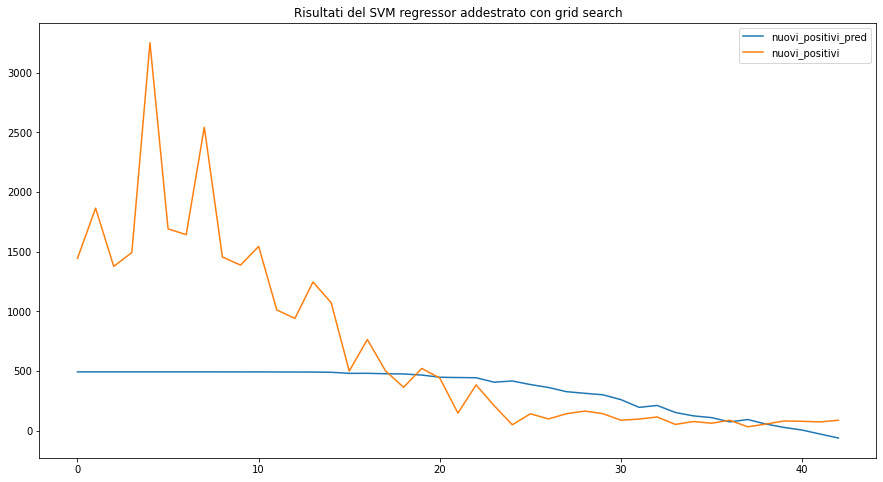

In [ ]:
plt.plot(predicted, label="nuovi_positivi_pred")
plt.plot(test_y.values, label="nuovi_positivi")
plt.legend()
plt.title("Risultati del SVM regressor addestrato con grid search")
plt.show()

### MODELLO: valutazione ed osservazioni ###

Vediamo le **caratteristiche** del miglior SVR trovato.

In [ ]:
best_regressor

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Si tratta di un SVR con kernel **lineare**.

Calcoliamo alcune **misure di performance** per il regressore. Abbiamo scelto quelle a parer nostro più significative:
* **R2**: coefficiente di determinazione
* **RMSE**: root mean squared error
* **MAX Error**: errore massimo

In [ ]:
print(f"R2: \t\t{r2_score(test_y, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y, predicted)}")

R2: 		0.0436
RMSE: 		7.47e+02
MAX ERR: 	2757.6619944922422


**Osserviamo** che le performance del miglior regressore svm addestrato sono ancora una volta abbastanza **buone**.

**R2** è **0.885**, ampiamente superiore a 0.5 ed abbastanza vicino ad 1 (R2 massimo). Il modello spiega gran parte della varianza dei dati.

**RMSE** è **61.8**, pertanto il nostro modello in media sbaglia il conteggio dei nuovi positivi di 62 unità. Seppur di primo acchitto sembri eccessivo, in realtà non lo è se si pensa che in alcune giornate sono stati registrati più di 1000 nuovi positivi.

**MAX ERR** è **245.24**. Dal grafico si nota come in un preciso giorno il predittore sbagli considerevolmente. Questo errore molto pronunciato va ad influenzare negativamente l'RMSE.

### Salvataggio e caricamento del modello ###

**Salviamo** il modello migliore trovato.

In [ ]:
save_scikit_model("SVR-grid", best_regressor)

NameError: ignored

**Carichiamo** il modello appena salvato per verificare che non ci siano stati errori nel salvataggio.

In [ ]:
loaded_model = load_scikit_model("models/SVR-grid-08-07-2020 18h38")

loaded_predicted = loaded_model.predict(test_X_imp)